## Binary Classification Deep Neural Network without any External Packages
### Completely built with just numpy

#### Import necessary Libraries

In [76]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import h5py

#### Load Training & Test data and flatten them

In [78]:
def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

#### Initialize the Weights ($W$) and Bias ($b$) for all the Hidden Layers

In [80]:
def intialize_parameters_deep(layers_dims):
    '''
    layer_dims -> python array (list) containing the dimensions of each layer in our network
    '''
    np.random.seed(1)
    parameters = {}
    L = len(layers_dims) # number of layers in the network

    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) / np.sqrt(layers_dims[l-1])
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))
        
    return parameters

#### Linear Forward Propagation using ReLU and Sigmoid Activation functions
$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$
- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$
- **ReLU**: The mathematical formula for ReLu is $A = RELU(Z) = max(0, Z)$

In [82]:
def Linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z = W.dot(A_prev) + b
        linear_cache = (A_prev, W, b)
        A = 1/(1 + np.exp(-Z))
        activation_cache = Z

    if activation == "ReLU":
        Z = W.dot(A_prev) + b
        linear_cache = (A_prev, W, b)
        A = np.maximum(0,Z)
        activation_cache = Z

    cache = (linear_cache, activation_cache)

    return A, cache

In the code below, the variable `yHat` will denote $\hat{Y} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$. 

In [84]:
def L_model_forward(X, parameters):
    '''
    returns:
    yHat -- activation value from the output (last) layer
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    '''
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A 
        A, cache = Linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activation = "ReLU")
        caches.append(cache)

    yHat, cache = Linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    return yHat, caches

#### Compute the cost
$$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$

In [86]:
def compute_cost(yHat, Y):
    m = Y.shape[1]

    term1 = Y * np.log(yHat)
    term2 = (1 - Y) * np.log(1 - yHat)
    cost = -1/m * np.sum((term1+term2), axis=1, keepdims=True)

    cost = np.squeeze(cost)

    return cost

#### Back Propagation

For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Suppose you have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. You want to get $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$.

The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ are computed using the input $dZ^{[l]}$.

Here are the formulas you need:
$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]}$$


$A^{[l-1] T}$ is the transpose of $A^{[l-1]}$. 

In [89]:
def ReLU_backward(dA, cache):
    """
    Implement the backward propagation for a single ReLU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1 + np.exp(-Z))
    dZ = dA * s * (1-s)
    
    return dZ
    
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1./m * np.dot(dZ, A_prev.T)
    db = 1./m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db 

`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}). \tag{11}$$ 

In [91]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == "ReLU":
        dZ = ReLU_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

To backpropagate through this network, you know that the output is: 
$A^{[L]} = \sigma(Z^{[L]})$. Your code thus needs to compute `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$.
To do so, use this formula (derived using calculus which, again, you don't need in-depth knowledge of!):

```python
dyHat = - (np.divide(Y, yHat) - np.divide(1 - Y, 1 - yHat)) # derivative of cost with respect to AL
```

In [93]:
def L_model_backward(yHat, Y, caches):
    """
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-true, 1 if true)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "ReLU" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # Number of Layers
    m = yHat.shape[1]
    
    Y = Y.reshape(yHat.shape)

    dyHat = - (np.divide(Y, yHat) - np.divide(1 - Y, 1 - yHat))

    # Lth Layer
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dyHat, current_cache, activation="sigmoid")
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation="ReLU")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads


$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{16}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17}$$

where $\alpha$ is the learning rate. 

In [95]:
def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - np.dot(learning_rate, grads["dW" + str(l+1)])
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - np.dot(learning_rate, grads["db" + str(l+1)])
        
    return parameters

### The main Function to Train the Deep Neural Network

In [97]:
def deepNeuralNetwork(X, Y, layers_dims, learning_rate = 0.01, num_iterations = 2500, print_cost = False):
    '''
    X -> Input data, (n_x, number of examples)
    Y -> True label vector containing true (1) or not true (0)

    Returns Parameters learned by the model
    '''
    np.random.seed(1) 
    costs = []

    parameters = intialize_parameters_deep(layers_dims)

    # Gradient Descent Loop
    for i in range(0, num_iterations):
        yHat, caches = L_model_forward(X, parameters)

        # Compute cost
        cost = compute_cost(yHat, Y)

        # Backward Propagation
        grads = L_model_backward(yHat, Y, caches)

        # Update Parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

### Initiate Training of the Neural Network

In [99]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

layers_dims = [train_x.shape[0], 20, 7, 5, 1]
parameters, costs = deepNeuralNetwork(train_x, train_y, layers_dims, num_iterations = 5000, print_cost = True)

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)
Cost after iteration 0: 0.7717493284237686
Cost after iteration 100: 0.6692696631401116
Cost after iteration 200: 0.6388738671173996
Cost after iteration 300: 0.5978842419394992
Cost after iteration 400: 0.5688271812027766
Cost after iteration 500: 0.46126000616108054
Cost after iteration 600: 0.508483606788839
Cost after iteration 700: 0.32759554824353215
Cost after iteration 800: 0.31039800057544936
Cost after iteration 900: 0.2488305281626642
Cost after iteration 1000: 0.20730930330849923
Cost after iteration 1100: 0.14048537378492812
Cost after iteration 1200: 0.11567032435733031
Cost after iteration 1300: 0.09925963099373135
Cost after iteration 1400: 0.08584462857591117
Cost after iteration 1500: 0.07497507157629976
Cost after iteration 1600: 0.06780881950806797
Cost after iteration 1700: 0.058401527166982846
Cost after iteration 1800: 0.05205409767343471
Cost after iteration 1900: 0.047679648995291854
Cost after iteration

### Predict the results on the training data and calculate Accuracy

In [101]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [123]:
pred_train = predict(train_x, train_y, parameters)
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.9999999999999998
Accuracy: 0.8


### Make prediction on an image entirely new

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


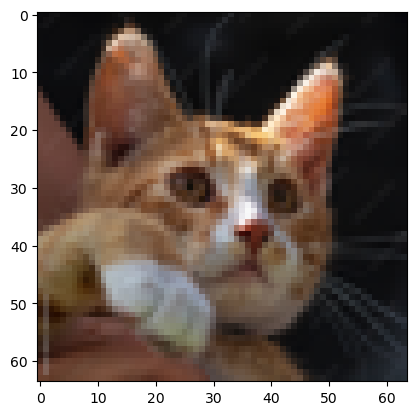

In [127]:
from PIL import Image
import numpy as np

my_image = "catImage.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
num_px = 64

fname = my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, parameters)


print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")